## UNLEARNING USING Selective Synaptic Dampening

The following notebook is an adaptation of the NeurIPS Unlearning Challenge Starter Notebook

In [1]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

import time

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18

Running on device: CUDA


Set the dataset_name to either 'cifar' or 'mnist'

In [29]:
dataset_name = 'mnist'

In [30]:
if(dataset_name == 'cifar'):
    # download and pre-process CIFAR10
    normalize = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

    train_set = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=normalize
    )
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

    # we split held out data into test and validation set
    held_out = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=normalize
    )
    test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

    # download the forget and retain index split
    local_path = "forget_idx.npy"
    if not os.path.exists(local_path):
        response = requests.get(
            "https://storage.googleapis.com/unlearning-challenge/" + local_path
        )
        open(local_path, "wb").write(response.content)
    forget_idx = np.load(local_path)
    print(len(forget_idx))
    # construct indices of retain from those of the forget set
    forget_mask = np.zeros(len(train_set.targets), dtype=bool)
    forget_mask[forget_idx] = True
    retain_idx = np.arange(forget_mask.size)[~forget_mask]

    # split train set into a forget and a retain set
    forget_set = torch.utils.data.Subset(train_set, forget_idx)
    retain_set = torch.utils.data.Subset(train_set, retain_idx)

    forget_loader = torch.utils.data.DataLoader(
        forget_set, batch_size=128, shuffle=True, num_workers=2
    )
    retain_loader = torch.utils.data.DataLoader(
        retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
    )

In [37]:
if(dataset_name == "mnist"):
    # Define the data transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Download and preprocess MNIST dataset
    train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

    test_set = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    # test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

    val_set, test_set = random_split(test_set, [5000, len(test_set) - 5000])
    val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

    # Download the forget and retain index split
    local_path = "forget_idx.npy"
    if not os.path.exists(local_path):
        response = requests.get(
            "https://storage.googleapis.com/unlearning-challenge/" + local_path
        )
        open(local_path, "wb").write(response.content)
    forget_idx = np.load(local_path)
    print(len(train_set.targets))

    # Construct indices of retain from those of the forget set
    forget_mask = np.zeros(len(train_set.targets), dtype=bool)
    forget_mask[forget_idx] = True
    retain_idx = np.arange(forget_mask.size)[~forget_mask]

    # Split train set into forget and retain sets
    forget_set = torch.utils.data.Subset(train_set, forget_idx)
    retain_set = torch.utils.data.Subset(train_set, retain_idx)

    forget_loader = torch.utils.data.DataLoader(
        forget_set, batch_size=128, shuffle=True, num_workers=2
    )
    retain_loader = torch.utils.data.DataLoader(
        retain_set, batch_size=128, shuffle=True, num_workers=2
    )


60000


We'll now download the weights of the model trained in CIFAR-10 and load them in a Pytorch model. This model has been trained using SGD with a learning rate of 0.1, momentum of 0.9 and weight decay of 5e-4. It was also trained using data augmentation. In particular, the transforms used to the data were:

```python
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
```


In [32]:
if(dataset_name == "mnist"):
    # Define the transforms and normalization values
    transform_for_training = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])


    # Load MNIST dataset with the specified transforms
    train_set_for_training = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform_for_training)
    train_loader_for_training = DataLoader(train_set_for_training, batch_size=128, shuffle=True, num_workers=2)

    test_set_for_training = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform_for_training)
    # test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

    val_set_for_training, test_set_for_training = random_split(test_set_for_training, [5000, len(test_set_for_training) - 5000])
    val_loader_for_training = DataLoader(val_set_for_training, batch_size=128, shuffle=False, num_workers=2)
    test_loader_for_training = DataLoader(test_set_for_training, batch_size=128, shuffle=False, num_workers=2)


    # Define ResNet model architecture with modified input layer
    model = resnet18(num_classes=10)  # MNIST has 10 classes (0-9 digits)

    # Modify the input layer to accept 1 channel instead of 3
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define optimizer and loss function
    # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    optimizer = optim.Adam(model.parameters(), lr = 2e-3)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader_for_training:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Calculate train accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in train_loader_for_training:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        train_accuracy = correct / total
        print(f"Train Accuracy: {train_accuracy:.4f}")
    # Save the model's weights
    torch.save(model.state_dict(), "resnet18_mnist.pth")

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader_for_training:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/30, Loss: 0.2714
Train Accuracy: 0.9496
Epoch 2/30, Loss: 0.1166
Train Accuracy: 0.9651
Epoch 3/30, Loss: 0.0903
Train Accuracy: 0.9762
Epoch 4/30, Loss: 0.0814
Train Accuracy: 0.9707
Epoch 5/30, Loss: 0.0733
Train Accuracy: 0.9749
Epoch 6/30, Loss: 0.0661
Train Accuracy: 0.9825
Epoch 7/30, Loss: 0.0643
Train Accuracy: 0.9818
Epoch 8/30, Loss: 0.0584
Train Accuracy: 0.9837
Epoch 9/30, Loss: 0.0555
Train Accuracy: 0.9833
Epoch 10/30, Loss: 0.0529
Train Accuracy: 0.9814
Epoch 11/30, Loss: 0.0521
Train Accuracy: 0.9829
Epoch 12/30, Loss: 0.0483
Train Accuracy: 0.9843
Epoch 13/30, Loss: 0.0466
Train Accuracy: 0.9826
Epoch 14/30, Loss: 0.0469
Train Accuracy: 0.9876
Epoch 15/30, Loss: 0.0443
Train Accuracy: 0.9853
Epoch 16/30, Loss: 0.0412
Train Accuracy: 0.9856
Epoch 17/30, Loss: 0.0412
Train Accuracy: 0.9876
Epoch 18/30, Loss: 0.0399
Train Accuracy: 0.9889
Epoch 19/30, Loss: 0.0366
Train Accuracy: 0.9896
Epoch 20/30, Loss: 0.0364
Train Accuracy: 0.9880
Epoch 21/30, Loss: 0.0368
Tra

In [33]:
if(dataset_name == "mnist"):
    # Define ResNet model architecture with modified input layer
    model_retain = resnet18(num_classes=10)  # MNIST has 10 classes (0-9 digits)

    # Modify the input layer to accept 1 channel instead of 3
    model_retain.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_retain.to(device)

    # Define optimizer and loss function
    # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    optimizer = optim.Adam(model_retain.parameters(), lr = 2e-5)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model_retain.train()
        running_loss = 0.0
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model_retain(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(retain_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Calculate train accuracy
        model_retain.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in retain_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model_retain(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        train_accuracy = correct / total
        print(f"Train Accuracy: {train_accuracy:.4f}")
    # Save the model's weights
    torch.save(model_retain.state_dict(), "resnet18_retain_mnist.pth")

    # # Evaluate the model on the test set
    # model_retain.eval()
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for inputs, targets in forge:
    #         inputs, targets = inputs.to(device), targets.to(device)
    #         outputs = model(inputs)
    #         _, predicted = torch.max(outputs, 1)
    #         total += targets.size(0)
    #         correct += (predicted == targets).sum().item()

    # test_accuracy = correct / total
    # print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10, Loss: 0.4599
Train Accuracy: 0.9673
Epoch 2/10, Loss: 0.1101
Train Accuracy: 0.9875
Epoch 3/10, Loss: 0.0581
Train Accuracy: 0.9956
Epoch 4/10, Loss: 0.0299
Train Accuracy: 0.9987
Epoch 5/10, Loss: 0.0163
Train Accuracy: 0.9998
Epoch 6/10, Loss: 0.0089
Train Accuracy: 0.9999
Epoch 7/10, Loss: 0.0054
Train Accuracy: 1.0000
Epoch 8/10, Loss: 0.0037
Train Accuracy: 1.0000
Epoch 9/10, Loss: 0.0023
Train Accuracy: 1.0000
Epoch 10/10, Loss: 0.0016
Train Accuracy: 1.0000


In [7]:
if(dataset_name == "cifar"):
    # download pre-trained weights
    local_path = "weights_resnet18_cifar10.pth"
    if not os.path.exists(local_path):
        response = requests.get(
            "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
        )
        open(local_path, "wb").write(response.content)

    weights_pretrained = torch.load(local_path, map_location=DEVICE)

    # load model with pre-trained weights
    model = resnet18(weights=None, num_classes=10)

    model.load_state_dict(weights_pretrained)
    model.to(DEVICE)
    model.eval();

In [8]:
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
if(dataset_name == 'mnist'):
    # download pre-trained weights
    local_path = "resnet18_mnist.pth"

    weights_pretrained = torch.load(local_path, map_location=DEVICE)

    # load model with pre-trained weights
    model = resnet18(weights=None, num_classes=10)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    model.load_state_dict(weights_pretrained)
    model.to(DEVICE)
    model.eval()

Let us show some of the training images, just for fun.

Files already downloaded and verified


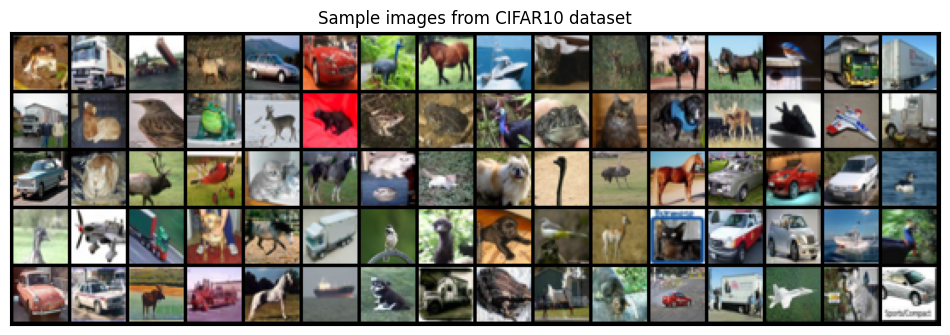

In [10]:
# a temporary data loader without normalization, just to show the images
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

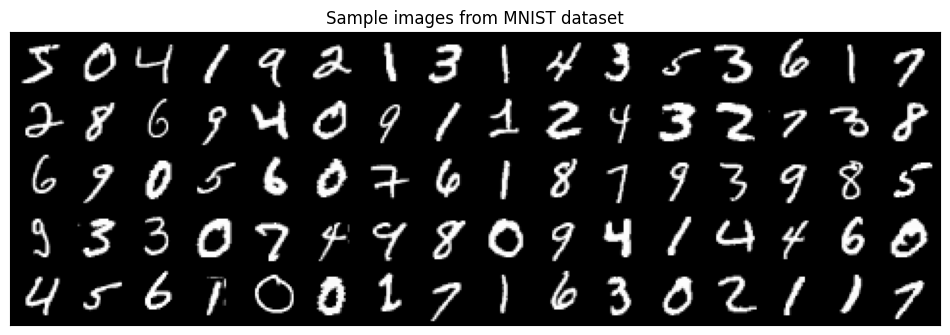

In [11]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Define temporary data loader without normalization
tmp_dl = DataLoader(
    torchvision.datasets.MNIST(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

# Display sample images from the MNIST dataset
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from MNIST dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0), cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()


We'll now compute the model's accuracy on the train and test set.


In [12]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 99.5%
Test set accuracy: 88.3%


# 🎯 Unlearning Algorithm

In this section we develop the unlearning algorithm.

In the previous section we created a split of the original training set into a retain set and a forget set. Typically, the retain set is much larger than the forget set. Here, we produce a split that is 10% forget set, and 90% retain set.

The goal of an unlearning algorithm is to produce a model that approximates as much as possible the model trained solely on the retain set.

Below is a simple unlearning algorithm provided for illustration purposes. We call this algorithm _unlearning by fine-tuning_. It starts from the pre-trained model and optimizes it for a few epochs on the retain set. This is a very simple unlearning algorithm, but it is not very computationally efficient, and we don't expect it to work very well for most metrics.

To make a new entry in the competition, participants will submit an unlearning function with the same API as the one below. Note that the unlearning function takes as input a pre-trained model, a retain set, a forget set and an evaluation set (even though the fine-tuning algorithm below only uses the retain set and ignores the other datasets).

In [13]:
import os
import subprocess

import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset, ConcatDataset, dataset, Subset

from typing import Dict, List

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Let $\text{imp}_{ij}^{(t)}$ represent the importance of parameter $i$ in layer $j$ at time step $t$.

The importance is calculated as the sum of squared gradients over multiple batches:

$$
\text{imp}_{ij}^{(t)} = \frac{1}{N} \sum_{k=1}^{N} \left( \frac{\partial \mathcal{L}_k}{\partial W_{ij}}^{(t)} \right)^2
$$

Where:
- $N$ is the total number of batches in the DataLoader.
- $\mathcal{L}_k$ is the loss function for batch $k$.
- $W_{ij}$ is the parameter of interest in layer $j$ of the model.

After calculating the importance for the original dataset and the forget sample, we modify the weights based on the SSD (Synaptic Dampening and Synapse Selection) equations:

$$
\text{weight}_{ij} = \left( \frac{\text{imp}_{ij}^{\text{orig}} \times \lambda}{\text{imp}_{ij}^{\text{forget}}} \right)^{\alpha}
$$

$$
\text{update}_{ij} = \text{weight}_{ij} \quad \text{if} \quad \text{imp}_{ij}^{\text{forget}} > \text{imp}_{ij}^{\text{orig}} \times \text{selection\_weighting}
$$

$$
\text{update}_{ij} = \text{lower\_bound} \quad \text{if} \quad \text{update}_{ij} < \text{lower\_bound}
$$

$$
W_{ij}^{(t+1)} = W_{ij}^{(t)} \times \text{update}_{ij}
$$

Where:
- $\text{imp}_{ij}^{\text{orig}}$ is the importance of parameter $i$ in layer $j$ for the original dataset.
- $\text{imp}_{ij}^{\text{forget}}$ is the importance of parameter $i$ in layer $j$ for the forget sample.
- $\lambda$ is the dampening constant.
- $\alpha$ is the exponent.
- $\text{selection\_weighting}$ is a hyperparameter that scales the importance threshold for synaptic selection.
- $\text{lower\_bound}$ is a lower bound to prevent parameters from increasing too much.


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np

def calculate_per_parameter_importance(model, dataloader) -> dict:
    """
    Calculates per-parameter importance based on a DataLoader.

    Parameters:
    - model: The neural network model
    - dataloader: DataLoader containing the dataset

    Returns:
    - importance_dict: Dictionary containing per-parameter importance values
    """
    criterion = nn.CrossEntropyLoss()  # Define the loss criterion (Cross Entropy in this case)
    importance_dict = {name: torch.zeros_like(param) for name, param in model.named_parameters()}  # Initialize importance_dict with zeros

    # Iterate through the dataloader to process each batch
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(model.device), targets.to(model.device)  # Move data to device
        model.optimizer.zero_grad()  # Zero out gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backward pass to compute gradients

        # Update importance_dict with squared gradients for each parameter
        for name, param in model.named_parameters():
            if param.grad is not None:  # Check if gradients exist for the parameter
                # Calculate and add squared gradients to importance_dict
                importance_dict[name].data += param.grad.data.clone().pow(2)  # imp_ij^(t) = (partial L_k / partial W_ij^(t))^2

    # Average the squared gradients over the entire dataset
    for importance_tensor in importance_dict.values():
        importance_tensor.data /= float(len(dataloader))  # imp_ij^(t) = (1/N) * sum_k=1^N (partial L_k / partial W_ij^(t))^2

    return importance_dict

def perturb_weights(model, original_importance, forget_importance):
    """
    Perturbs weights based on specified equations.

    Parameters:
    - model: The neural network model
    - original_importance: Dictionary containing original per-parameter importance values
    - forget_importance: Dictionary containing forget dataset per-parameter importance values
    """
    with torch.no_grad():
        for name, param in model.named_parameters():
            orig_importance_norm = original_importance[name].mul(model.config["selection_weighting"])
            locations = torch.where(forget_importance[name] > orig_importance_norm)
            weight = ((original_importance[name].mul(model.config["dampening_constant"])).div(forget_importance[name])).pow(model.config["exponent"])
            update = weight[locations]
            update.clamp_(min=model.config["lower_bound"], max=1.0)  # Clamping to prevent parameter values from increasing.
            param[locations] *= update

def unlearn(model, retain_loader, forget_loader, val_loader, device='cuda', dataset_name='cifar'):
    """
    Executes the unlearning routine on the neural network model.

    Parameters:
    - model: The neural network model
    - retain_loader: DataLoader for the retained dataset
    - forget_loader: DataLoader for the forget dataset
    - val_loader: DataLoader for the validation dataset
    - device: Device to use for computation (default is 'cuda')
    - dataset_name: Name of the dataset (default is 'cifar')

    Returns:
    - model: Updated neural network model after unlearning
    """
    model.to(device)  # Move the model to the specified device
    epochs = 1
    criterion = nn.CrossEntropyLoss()
    optimizer_model = optim.SGD(model.parameters(), lr=0.1)
    model.optimizer = optimizer_model  # Store optimizer in the model object
    model.device = device  # Update model device attribute

    lambda_val = 10  # Default value for non-MNIST datasets
    if dataset_name == 'mnist':
        lambda_val = 50  # Update lambda value for MNIST dataset

    alpha_val = 1  # alpha in the paper
    selection_weighting_val = 10 * alpha_val  # Selection weighting value

    config_dict = {
        "lower_bound": 1,
        "exponent": 1,
        "magnitude_diff": None,
        "min_layer": -1,
        "max_layer": -1,
        "forget_threshold": 1,
        "dampening_constant": lambda_val,
        "selection_weighting": selection_weighting_val,
    }

    full_train_loader = DataLoader(
        ConcatDataset((retain_loader.dataset, forget_loader.dataset)),
        batch_size=64,
        shuffle=True,  # Shuffle the data to improve training efficiency
        num_workers=4,  # Utilize multiple CPU cores for data loading
    )

    model.config = config_dict  # Store model configuration in the model object

    sample_importances = calculate_per_parameter_importance(model, forget_loader)
    original_importances = calculate_per_parameter_importance(model, full_train_loader)
    perturb_weights(model, original_importances, sample_importances)

    model.eval()

    return model


In [15]:
import copy
ft_model = resnet18(weights=None, num_classes=10)
# Modify the input layer to accept 1 channel instead of 3
if(dataset_name == 'mnist'):
  ft_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  ft_model.load_state_dict(weights_pretrained)
else:
  ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

start_time_total = time.time()  # Record the start time for total execution time

for i in range(50):
    print(i)
    ft_model = unlearn(ft_model, retain_loader, forget_loader, test_loader, dataset_name=dataset_name)

end_time_total = time.time()  # Record the end time for total execution time
total_elapsed_time = end_time_total - start_time_total  # Calculate the total elapsed time
print(f"Total time taken for 50 iterations: {total_elapsed_time:.2f} seconds")

0
1


KeyboardInterrupt: 

We have now an unlearned model `ft_model`. Besides the forgetting quality (which we'll discuss in the next section), a good unlearning algorithm should retain as much as possible the accuracy on the retain and test set.

To quantify this potential loss of utility, we'll now compute the retain and test accuracies using the unlearned model

In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")

Retain set accuracy: 100.0%
Test set accuracy: 97.9%


In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Retain set accuracy: 98.9%
Test set accuracy: 98.7%


# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [16]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

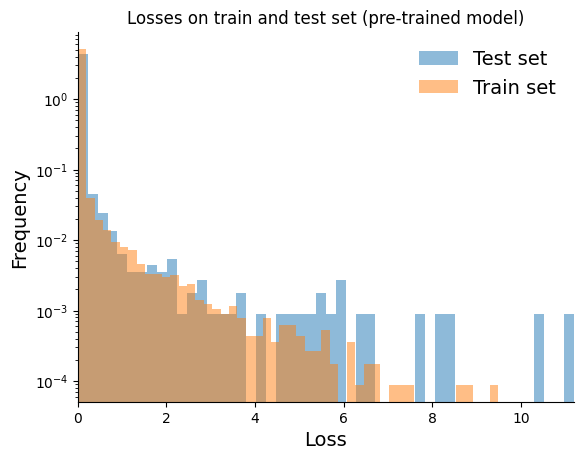

In [ ]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

As per the above plot, the distributions of losses are quite different between the train and test sets, as expected. In what follows, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't. Using this fact, the simple MIA defined below will aim to infer whether the forget set was in fact part of the training set.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes.

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set any better than it would for the ideal unlearning algorithm (retraining from scratch without the retain set); see the last section of this notebook for additional discussion and for computing that reference point.

In [17]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [ ]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.507 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [ ]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [ ]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.496 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

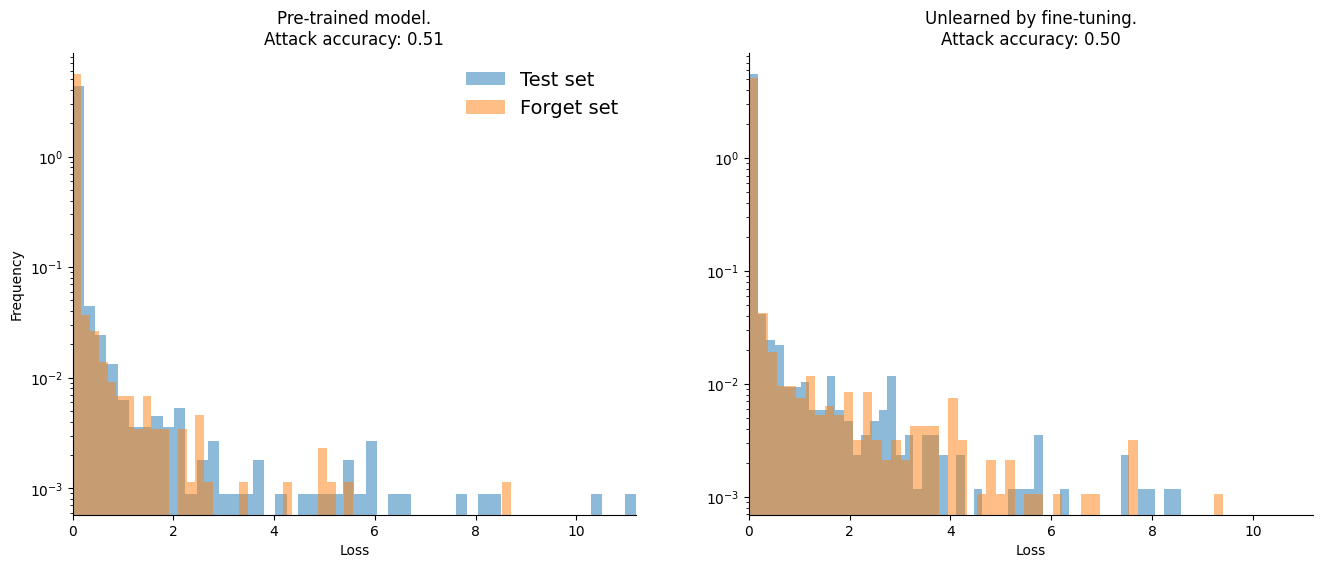

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

One might ask, how good are the scores above? What is the best score? Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

We'll now compute this score. We'll first download the weights for a model trained exclusively on the retain set and then compute the accuracy of the simple MIA.

In [ ]:
if(dataset_name == "cifar"):
    # download weights of a model trained exclusively on the retain set
    local_path = "retrain_weights_resnet18_cifar10.pth"
    if not os.path.exists(local_path):
        response = requests.get(
            "https://storage.googleapis.com/unlearning-challenge/" + local_path
        )
        open(local_path, "wb").write(response.content)

    weights_pretrained = torch.load(local_path, map_location=DEVICE)
    # load model with pre-trained weights
    rt_model = resnet18(weights=None, num_classes=10)
    rt_model.load_state_dict(weights_pretrained)
    rt_model.to(DEVICE)
    rt_model.eval()

    # print its accuracy on retain and forget set
    print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
    print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Retain set accuracy: 99.5%
Forget set accuracy: 88.2%


In [ ]:
if(dataset_name == "mnist"):
    # download weights of a model trained exclusively on the retain set
    local_path = "resnet18_retain_mnist.pth"

    weights_pretrained = torch.load(local_path, map_location=DEVICE)

    # load model with pre-trained weights
    rt_model = resnet18(weights=None, num_classes=10)
    rt_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    rt_model.load_state_dict(weights_pretrained)
    rt_model.to(DEVICE)
    rt_model.eval()

    # print its accuracy on retain and forget set
    print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
    print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")


As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set (whose accuracy is similar than on the test set)

In [ ]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [ ]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.496 on forgotten vs unseen images


As we expect, the accuracy of the MIA attack is roughly 0.5. Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

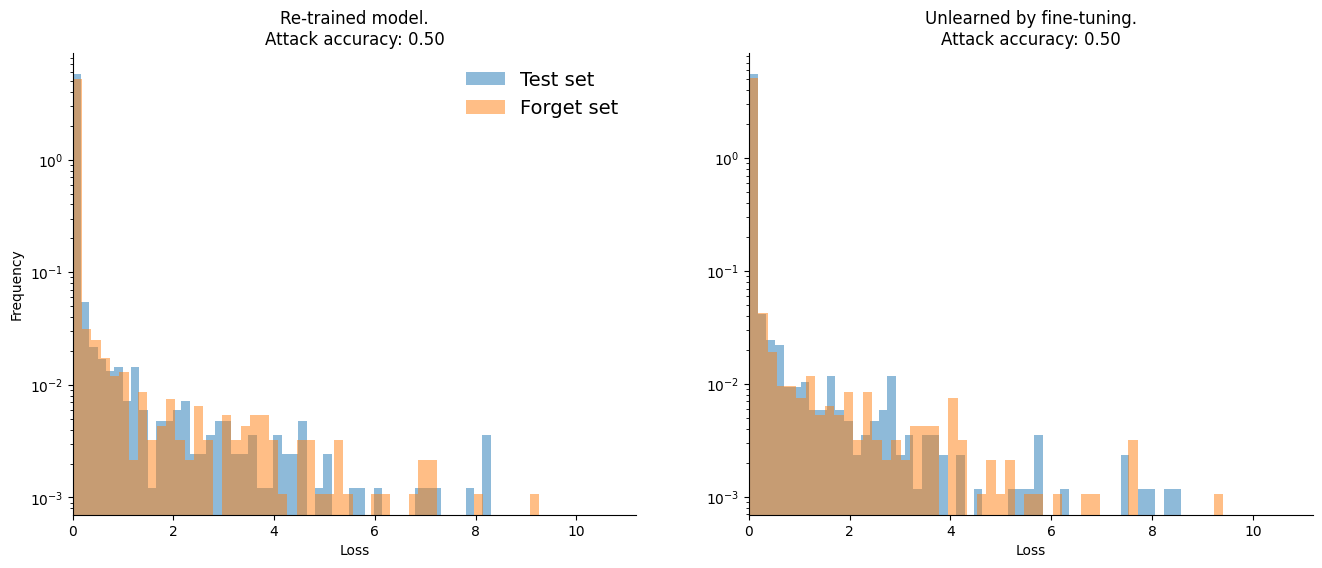

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

What we really want from unlearning is different from "predicting wrong for a certain set of datapoints", we want it to have never seen the data before. Hence more often than not the metrics used for unlearning are pitted against those of a model trained explicitly on the retained data.

This we can check via various methods, one is the method discussed above from the challenge itself. We expect the histogram of losses to look quite similar for both Test and Forget set, i.e. we expect the model to not have seen either of these data before and hence we expect the model to have similar histogram losses for both of them.

The following is the code to measure the ZRF score as per https://arxiv.org/pdf/2205.08096.pdf . Its selling point is the non-comparison with the gold standard model.

In [18]:
from torch.nn import functional as F

def JSDiv(p, q):
    m = (p+q)/2
    # print(F.kl_div(torch.log(p), m))
    # print(F.kl_div(torch.log(q), m))
    # print(torch.log(p))
    return 0.5*F.kl_div(torch.log(p), m) + 0.5*F.kl_div(torch.log(q), m)

# ZRF/UnLearningScore
def UnLearningScore(tmodel, gold_model, forget_dl, batch_size, device):
    model_preds = []
    gold_model_preds = []
    with torch.no_grad():
        for batch in forget_dl:
            x, y = batch
            x = x.to(device)
            model_output = tmodel(x)
            gold_model_output = gold_model(x)
            model_preds.append(F.softmax(model_output, dim = 1).detach().cpu())
            gold_model_preds.append(F.softmax(gold_model_output, dim = 1).detach().cpu())


    # Assuming model_preds is your tensor
    model_preds = torch.cat(model_preds, axis=0)  # Replace torch.float32 with your desired precision
    model_preds += torch.tensor(1e-45)

    zero_indices = torch.where(model_preds == 0)


    gold_model_preds = torch.cat(gold_model_preds, axis = 0)
    return 1-JSDiv(model_preds, gold_model_preds)


In [19]:
import torch
from torch.nn import functional as F

def calculate_JSD(p, q):
    """
    Calculate Jensen-Shannon Divergence (JSD) between probability distributions p and q.
    """
    m = 0.5 * (p + q)
    kl_div_1 = F.kl_div(torch.log(p), m)  # KL divergence from p to m
    kl_div_2 = F.kl_div(torch.log(q), m)  # KL divergence from q to m
    return 0.5 * kl_div_1 + 0.5 * kl_div_2  # JSD is the average of the two KL divergences

def compute_ZRF(unlearning_model, teacher_model, data_loader, batch_size, device):
    """
    Compute the UnLearning Score between two models using the Jensen-Shannon Divergence (JSD).

    Parameters:
    - unlearning_model: The model whose predictions are being evaluated.
    - teacher_model: The reference model for comparison.
    - data_loader: DataLoader object containing the evaluation data.
    - batch_size: Batch size for processing data.
    - device: Device to run computations (e.g., 'cuda' for GPU, 'cpu' for CPU).

    Returns:
    - unlearning_score: The UnLearning Score based on JSD.
    """
    predictions_unlearning = []
    predictions_teacher = []

    # Evaluate models on data_loader without gradient computation
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            # Compute model predictions
            outputs_unlearning = unlearning_model(inputs)
            outputs_teacher = teacher_model(inputs)
            # Apply softmax and detach from computation graph
            predictions_unlearning.append(F.softmax(outputs_unlearning, dim=1).detach().cpu())
            predictions_teacher.append(F.softmax(outputs_teacher, dim=1).detach().cpu())

    # Concatenate predictions and add a small value for numerical stability
    predictions_unlearning = torch.cat(predictions_unlearning, dim=0)
    predictions_unlearning += torch.tensor(1e-6)  # Adding a small value for numerical stability
    predictions_teacher = torch.cat(predictions_teacher, dim=0)

    # Compute UnLearning Score based on JSD between model predictions
    unlearning_score = 1 - calculate_JSD(predictions_unlearning, predictions_teacher)
    return unlearning_score


In [ ]:
incompetant_teacher_model = resnet18(weights=None, num_classes=10)
if(dataset_name == 'mnist'):
  incompetant_teacher_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
incompetant_teacher_model.to(DEVICE)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print("Our Score: {}".format(compute_ZRF(ft_model, incompetant_teacher_model, forget_loader, 256, 'cuda')))

Our Score: 0.7766313552856445


/home/bharatgptv/miniconda3/envs/unlearning/lib/python3.12/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [ ]:
print("Our Score: {}".format(UnLearningScore(ft_model, incompetant_teacher_model, test_loader, 256, 'cuda')))

Our Score: 0.7559629678726196


In [ ]:
print("Our Score: {}".format(UnLearningScore(model_retain, incompetant_teacher_model, forget_loader, 256, 'cuda')))

Our Score: 0.7570310235023499


In [ ]:
print("Our Score: {}".format(UnLearningScore(model, incompetant_teacher_model, forget_loader, 256, 'cuda')))

Our Score: 0.6050841808319092


In [ ]:
print("Our Score: {}".format(UnLearningScore(model, incompetant_teacher_model, test_loader, 256, 'cuda')))

Our Score: 0.607590913772583


/home/bharatgptv/miniconda3/envs/unlearning/lib/python3.12/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


### All Combined Pipeline

In [ ]:
def main(weights_pretrained, dataset_name = 'cifar10'):
    ft_model = resnet18(weights=None, num_classes=10)
    # Modify the input layer to accept 1 channel instead of 3
    if(dataset_name == 'mnist'):
        ft_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        ft_model.load_state_dict(weights_pretrained)
    else:
        ft_model.load_state_dict(weights_pretrained)
    ft_model.to(DEVICE)

    start_time_total = time.time()  # Record the start time for total execution time

    for i in range(50):
        # print(i)
        ft_model = unlearn(ft_model, retain_loader, forget_loader, test_loader, dataset_name=dataset_name)

    end_time_total = time.time()  # Record the end time for total execution time
    total_elapsed_time = end_time_total - start_time_total  # Calculate the total elapsed time
    print(f"Total time taken for 50 iterations: {total_elapsed_time:.2f} seconds")


    accuracy_retain_unlearn = 100.0 * accuracy(ft_model, retain_loader)
    accuracy_test_unlearn = 100.0 * accuracy(ft_model, test_loader)

    accuracy_retain_model = 100.0 * accuracy(model, retain_loader)
    accuracy_test_model = 100.0 * accuracy(model, test_loader)
    print(f"Retain set accuracy for unlearning model: {accuracy_retain_unlearn:0.1f}%")
    print(f"Test set accuracy for unlearning model: {accuracy_test_unlearn:0.1f}%")

    print(f"Retain set accuracy for original model: {accuracy_retain_model:0.1f}%")
    print(f"Test set accuracy for original model: {accuracy_test_model:0.1f}%")

    train_losses = compute_losses(model, train_loader)
    test_losses = compute_losses(model, test_loader)

    # plot losses on train and test set
    plt.title("Losses on train and test set (pre-trained model)")
    plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
    plt.xlabel("Loss", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim((0, np.max(test_losses)))
    plt.yscale("log")
    plt.legend(frameon=False, fontsize=14)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.show()

    forget_losses = compute_losses(model, forget_loader)

    # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(test_losses)]

    samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)

    print(
        f"The MIA for the original model has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
    )

    ft_forget_losses = compute_losses(ft_model, forget_loader)
    ft_test_losses = compute_losses(ft_model, test_loader)

    # make sure we have a balanced dataset for the MIA
    assert len(ft_test_losses) == len(ft_forget_losses)

    ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

    ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

    print(
        f"The MIA for unlearned model has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
    )


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
    ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    ax2.set_title(
        f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
    )
    ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    ax1.set_xlabel("Loss")
    ax2.set_xlabel("Loss")
    ax1.set_ylabel("Frequency")
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_xlim((0, np.max(test_losses)))
    ax2.set_xlim((0, np.max(test_losses)))
    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax1.legend(frameon=False, fontsize=14)
    plt.show()

    if(dataset_name == "cifar"):
        # download weights of a model trained exclusively on the retain set
        local_path = "retrain_weights_resnet18_cifar10.pth"
        if not os.path.exists(local_path):
            response = requests.get(
                "https://storage.googleapis.com/unlearning-challenge/" + local_path
            )
            open(local_path, "wb").write(response.content)

        weights_pretrained = torch.load(local_path, map_location=DEVICE)
        # load model with pre-trained weights
        rt_model = resnet18(weights=None, num_classes=10)
        rt_model.load_state_dict(weights_pretrained)
        rt_model.to(DEVICE)
        rt_model.eval()

        # print its accuracy on retain and forget set
        print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
        print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

    if(dataset_name == "mnist"):
        # download weights of a model trained exclusively on the retain set
        local_path = "resnet18_retain_mnist.pth"

        weights_pretrained = torch.load(local_path, map_location=DEVICE)

        # load model with pre-trained weights
        rt_model = resnet18(weights=None, num_classes=10)
        rt_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        rt_model.load_state_dict(weights_pretrained)
        rt_model.to(DEVICE)
        rt_model.eval()

        # print its accuracy on retain and forget set
        print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
        print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

    rt_test_losses = compute_losses(rt_model, test_loader)
    rt_forget_losses = compute_losses(rt_model, forget_loader)

    rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

    rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

    print(
        f"The MIA for retrained model has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
    ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    ax2.set_title(
        f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
    )
    ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    ax1.set_xlabel("Loss")
    ax2.set_xlabel("Loss")
    ax1.set_ylabel("Frequency")
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_xlim((0, np.max(test_losses)))
    ax2.set_xlim((0, np.max(test_losses)))
    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax1.legend(frameon=False, fontsize=14)
    plt.show()

    incompetant_teacher_model = resnet18(weights=None, num_classes=10)
    if(dataset_name == 'mnist'):
        incompetant_teacher_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    incompetant_teacher_model.to(DEVICE)

    print("Our Score for unlearned model and forget loader: {}".format(compute_ZRF(ft_model, incompetant_teacher_model, forget_loader, 256, 'cuda')))
    print("Our Score for retrained model and forget loader: {}".format(compute_ZRF(rt_model, incompetant_teacher_model, forget_loader, 256, 'cuda')))
    print("Our Score for original model and forget loader: {}".format(compute_ZRF(model, incompetant_teacher_model, forget_loader, 256, 'cuda')))

Total time taken for 50 iterations: 1021.71 seconds
Retain set accuracy for unlearning model: 100.0%
Test set accuracy for unlearning model: 97.9%
Retain set accuracy for original model: 98.9%
Test set accuracy for original model: 98.7%


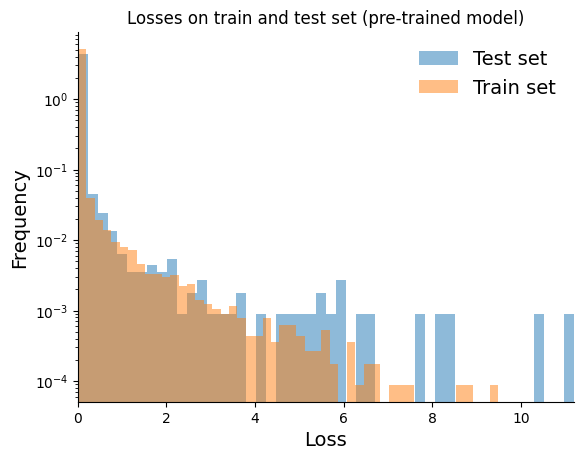

The MIA has an accuracy of 0.503 on forgotten vs unseen images
The MIA has an accuracy of 0.496 on forgotten vs unseen images


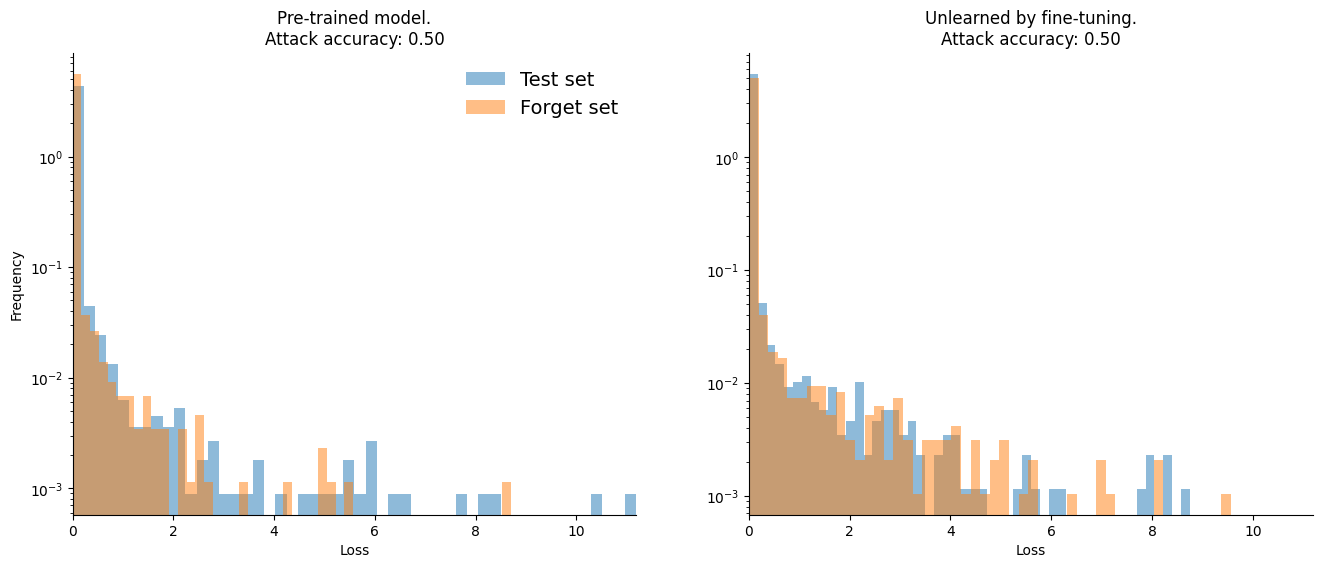

Retain set accuracy: 100.0%
Forget set accuracy: 98.0%
The MIA has an accuracy of 0.495 on forgotten vs unseen images


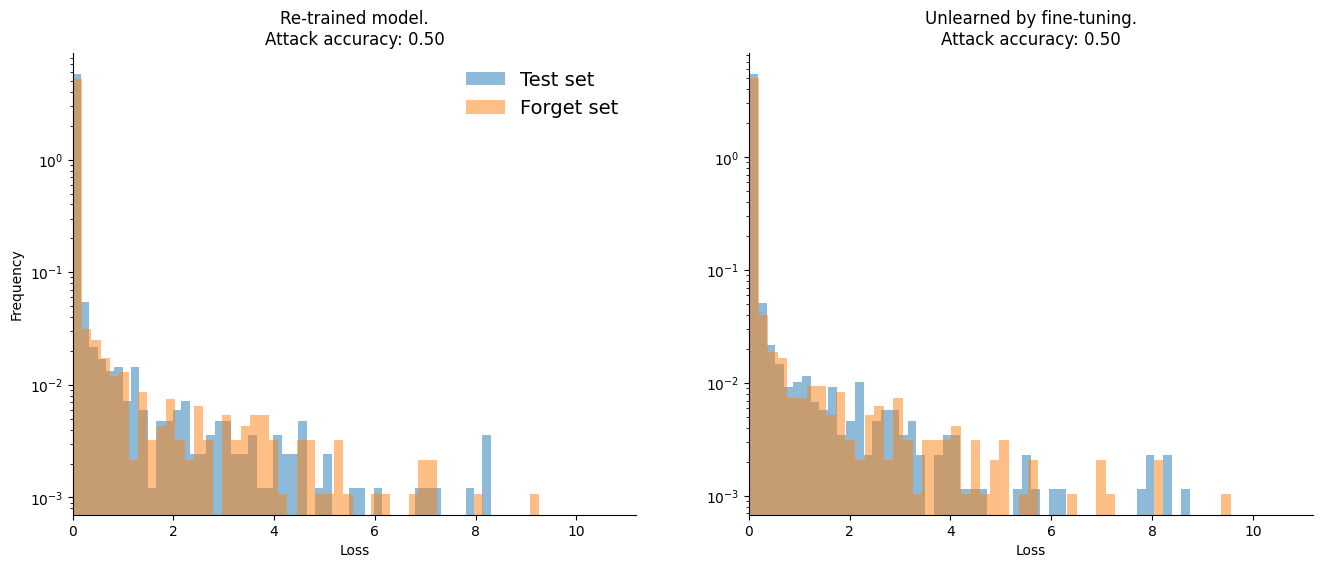

Our Score: 0.7773083448410034


/home/bharatgptv/miniconda3/envs/unlearning/lib/python3.12/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Our Score: 0.7604713439941406
Our Score: 0.6157277822494507


In [ ]:
if __name__ == "__main__":
    main(weights_pretrained, dataset_name)

Total time taken for 50 iterations: 994.90 seconds
Retain set accuracy for unlearning model: 97.8%
Test set accuracy for unlearning model: 86.4%
Retain set accuracy for original model: 99.5%
Test set accuracy for original model: 88.3%


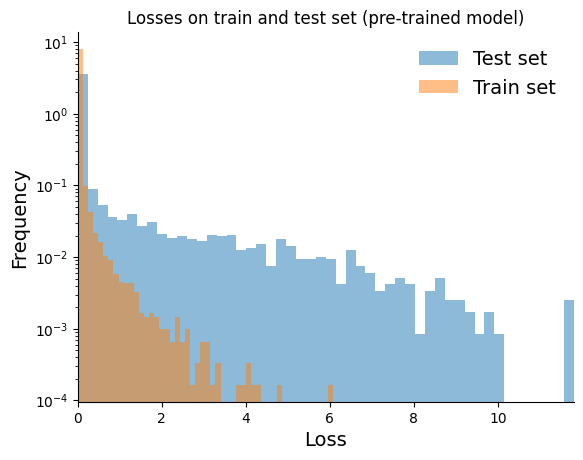

The MIA has an accuracy of 0.577 on forgotten vs unseen images
The MIA has an accuracy of 0.570 on forgotten vs unseen images


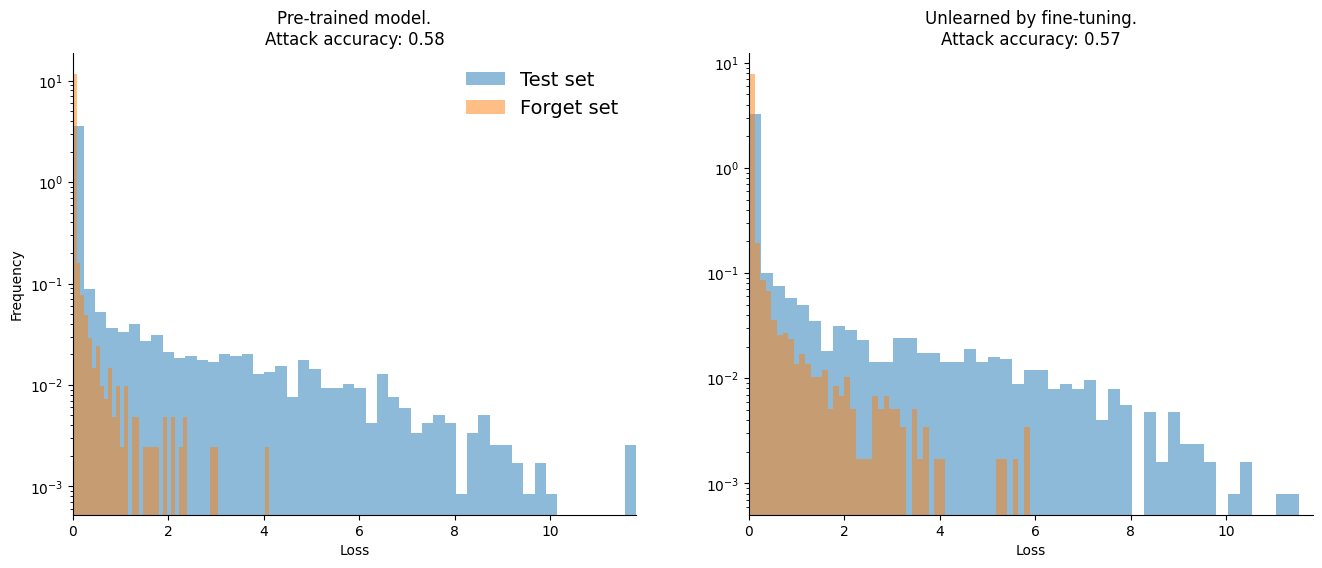

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%
The MIA has an accuracy of 0.502 on forgotten vs unseen images


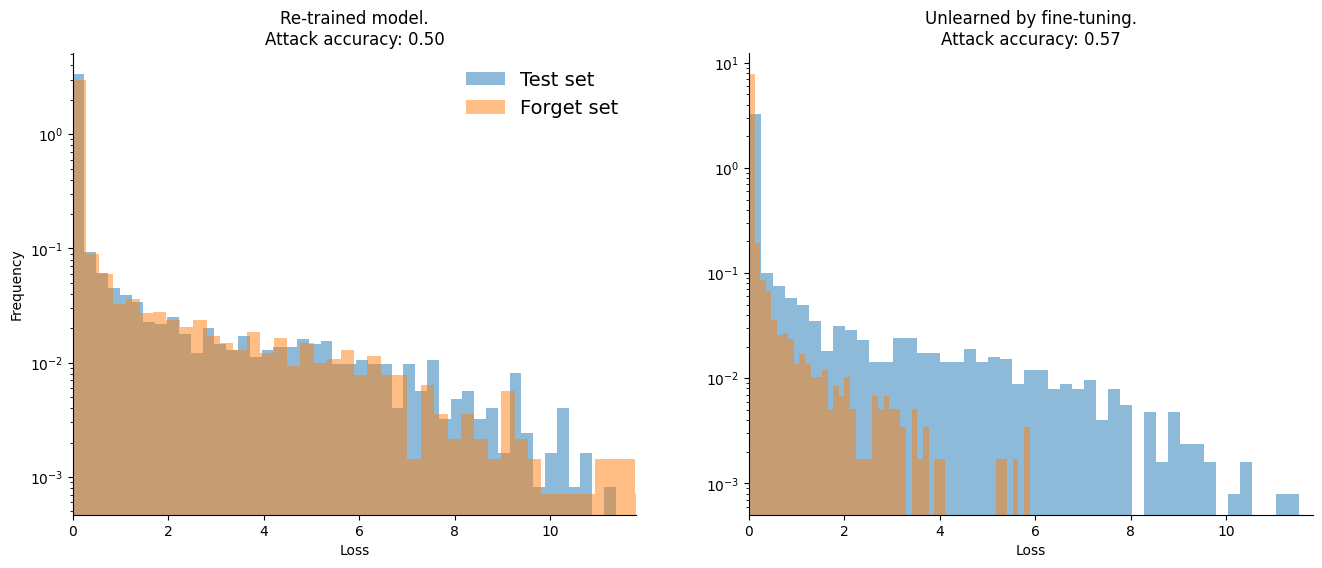

Our Score for unlearned model and forget loader: 0.822402834892273


/home/bharatgptv/miniconda3/envs/unlearning/lib/python3.12/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Our Score for retrained model and forget loader: 0.825131893157959
Our Score for original model and forget loader: 0.8154691457748413


In [ ]:
if __name__ == "__main__":
    main(weights_pretrained, dataset_name)

# Bad Teacher Unlearning

In [20]:
import torch
from torch.utils.data import Dataset
from torch.nn import functional as F
from torch import nn

In [21]:
class UnLearningData(Dataset):
    def __init__(self, forget_data, retain_data):
        super().__init__()
        self.forget_data = forget_data
        self.retain_data = retain_data
        self.forget_len = len(forget_data)
        self.retain_len = len(retain_data)

    def __len__(self):
        return self.retain_len + self.forget_len

    def __getitem__(self, index):
        if(index < self.forget_len):
            x = self.forget_data[index][0]
            y = 1
            return x,y
        else:
            x = self.retain_data[index - self.forget_len][0]
            y = 0
            return x,y

In [22]:
def training_step(model, batch, device):
    images, labels, clabels = batch
    images, clabels = images.to(device), clabels.to(device)
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, clabels) # Calculate loss
    return loss

def validation_step(model, batch, device):
    images, labels, clabels = batch
    images, clabels = images.to(device), clabels.to(device)
    out = model(images)                    # Generate predictions
    loss = F.cross_entropy(out, clabels)   # Calculate loss
    acc = accuracy(out, clabels)           # Calculate accuracy
    return {'Loss': loss.detach(), 'Acc': acc}

def validation_epoch_end(model, outputs):
    batch_losses = [x['Loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['Acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'Loss': epoch_loss.item(), 'Acc': epoch_acc.item()}


@torch.no_grad()
def evaluate(model, val_loader, device):
    model.eval()
    outputs = [validation_step(model, batch, device) for batch in val_loader]
    return validation_epoch_end(model, outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [23]:
def UnlearnerLoss(output, labels, full_teacher_logits, unlearn_teacher_logits):
    labels = torch.unsqueeze(labels, dim = 1)

    f_teacher_out = F.softmax(full_teacher_logits, dim=1)
    u_teacher_out = F.softmax(unlearn_teacher_logits, dim=1)

    overall_teacher_out = labels * u_teacher_out + (1-labels)*f_teacher_out
    student_out = F.log_softmax(output, dim=1)
    return F.kl_div(student_out, overall_teacher_out)

def unlearning_step(model, unlearning_teacher, good_teacher, unlearn_data_loader, optimizer,
            device):
    losses = []
    for batch in unlearn_data_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            full_teacher_logits = good_teacher(x)
            unlearn_teacher_logits = unlearning_teacher(x)
        output = model(x)
        optimizer.zero_grad()
        loss = UnlearnerLoss(output = output, labels=y, full_teacher_logits=full_teacher_logits,
                unlearn_teacher_logits=unlearn_teacher_logits)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    return np.mean(losses)

def blindspot_unlearner(model, unlearning_teacher, good_teacher, retain_data, forget_data, epochs = 10,
                optimizer = 'adam', lr = 0.01, batch_size = 256, num_workers = 32,
                device = 'cuda'):
    # creating the unlearning dataset.
    unlearning_data = UnLearningData(forget_data=forget_data, retain_data=retain_data)
    unlearning_loader = DataLoader(unlearning_data, batch_size = batch_size, shuffle=True,
                            num_workers=num_workers, pin_memory=True)

    unlearning_teacher.eval()
    good_teacher.eval()
    optimizer = optimizer
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    else:
        # if optimizer is not a valid string, then assuming it as a function to return optimizer
        optimizer = optimizer#(model.parameters())

    for epoch in range(epochs):
        loss = unlearning_step(model = model, unlearning_teacher= unlearning_teacher,
                        good_teacher=good_teacher, unlearn_data_loader=unlearning_loader,
                        optimizer=optimizer, device=device)
        print("Epoch {} Unlearning Loss {}".format(epoch+1, loss))

In [40]:
def blindspot_main(weights_pretrained, dataset_name = 'cifar'):
    unlearning_teacher = resnet18(weights=None, num_classes=10)
    if(dataset_name == 'mnist'):
        unlearning_teacher.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    unlearning_teacher.to(DEVICE)
    ft_model = resnet18(weights=None, num_classes=10)
    # Modify the input layer to accept 1 channel instead of 3
    if(dataset_name == 'mnist'):
        ft_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        ft_model.load_state_dict(weights_pretrained)
    else:
        ft_model.load_state_dict(weights_pretrained)
    ft_model.to(DEVICE)

    start_time_total = time.time()  # Record the start time for total execution time

    blindspot_unlearner(ft_model, unlearning_teacher, model, retain_set, forget_set, device=DEVICE)

    end_time_total = time.time()  # Record the end time for total execution time
    total_elapsed_time = end_time_total - start_time_total  # Calculate the total elapsed time
    print(f"Total time taken for 10 iterations: {total_elapsed_time:.2f} seconds")


    accuracy_retain_unlearn = 100.0 * accuracy(ft_model, retain_loader)
    accuracy_test_unlearn = 100.0 * accuracy(ft_model, test_loader)

    accuracy_retain_model = 100.0 * accuracy(model, retain_loader)
    accuracy_test_model = 100.0 * accuracy(model, test_loader)
    print(f"Retain set accuracy for unlearning model: {accuracy_retain_unlearn:0.1f}%")
    print(f"Test set accuracy for unlearning model: {accuracy_test_unlearn:0.1f}%")

    print(f"Retain set accuracy for original model: {accuracy_retain_model:0.1f}%")
    print(f"Test set accuracy for original model: {accuracy_test_model:0.1f}%")

    train_losses = compute_losses(model, train_loader)
    test_losses = compute_losses(model, test_loader)

    # plot losses on train and test set
    plt.title("Losses on train and test set (pre-trained model)")
    plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
    plt.xlabel("Loss", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim((0, np.max(test_losses)))
    plt.yscale("log")
    plt.legend(frameon=False, fontsize=14)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.show()

    forget_losses = compute_losses(model, forget_loader)

    # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(test_losses)]

    samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)

    print(
        f"The MIA for the original model has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
    )

    ft_forget_losses = compute_losses(ft_model, forget_loader)
    ft_test_losses = compute_losses(ft_model, test_loader)

    # make sure we have a balanced dataset for the MIA
    assert len(ft_test_losses) == len(ft_forget_losses)

    ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

    ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

    print(
        f"The MIA for unlearned model has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
    )


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
    ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    ax2.set_title(
        f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
    )
    ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    ax1.set_xlabel("Loss")
    ax2.set_xlabel("Loss")
    ax1.set_ylabel("Frequency")
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_xlim((0, np.max(test_losses)))
    ax2.set_xlim((0, np.max(test_losses)))
    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax1.legend(frameon=False, fontsize=14)
    plt.show()

    if(dataset_name == "cifar"):
        # download weights of a model trained exclusively on the retain set
        local_path = "retrain_weights_resnet18_cifar10.pth"
        if not os.path.exists(local_path):
            response = requests.get(
                "https://storage.googleapis.com/unlearning-challenge/" + local_path
            )
            open(local_path, "wb").write(response.content)

        weights_pretrained = torch.load(local_path, map_location=DEVICE)
        # load model with pre-trained weights
        rt_model = resnet18(weights=None, num_classes=10)
        rt_model.load_state_dict(weights_pretrained)
        rt_model.to(DEVICE)
        rt_model.eval()

        # print its accuracy on retain and forget set
        print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
        print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

    if(dataset_name == "mnist"):
        # download weights of a model trained exclusively on the retain set
        local_path = "resnet18_retain_mnist.pth"

        weights_pretrained = torch.load(local_path, map_location=DEVICE)

        # load model with pre-trained weights
        rt_model = resnet18(weights=None, num_classes=10)
        rt_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        rt_model.load_state_dict(weights_pretrained)
        rt_model.to(DEVICE)
        rt_model.eval()

        # print its accuracy on retain and forget set
        print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
        print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

    rt_test_losses = compute_losses(rt_model, test_loader)
    rt_forget_losses = compute_losses(rt_model, forget_loader)

    rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

    rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

    print(
        f"The MIA for retrained model has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
    ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    ax2.set_title(
        f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
    )
    ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    ax1.set_xlabel("Loss")
    ax2.set_xlabel("Loss")
    ax1.set_ylabel("Frequency")
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_xlim((0, np.max(test_losses)))
    ax2.set_xlim((0, np.max(test_losses)))
    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax1.legend(frameon=False, fontsize=14)
    plt.show()

    incompetant_teacher_model = resnet18(weights=None, num_classes=10)
    if(dataset_name == 'mnist'):
        incompetant_teacher_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    incompetant_teacher_model.to(DEVICE)

    print("Our Score for unlearned model and forget loader: {}".format(compute_ZRF(ft_model, incompetant_teacher_model, forget_loader, 256, 'cuda')))
    print("Our Score for retrained model and forget loader: {}".format(compute_ZRF(rt_model, incompetant_teacher_model, forget_loader, 256, 'cuda')))
    print("Our Score for original model and forget loader: {}".format(compute_ZRF(model, incompetant_teacher_model, forget_loader, 256, 'cuda')))

/home/bharatgptv/miniconda3/envs/unlearning/lib/python3.12/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1 Unlearning Loss 0.12019188702106476
Epoch 2 Unlearning Loss 0.0902910828590393
Epoch 3 Unlearning Loss 0.07796841859817505
Epoch 4 Unlearning Loss 0.06937774270772934
Epoch 5 Unlearning Loss 0.06254066526889801
Epoch 6 Unlearning Loss 0.05574498698115349
Epoch 7 Unlearning Loss 0.04994853585958481
Epoch 8 Unlearning Loss 0.045208871364593506
Epoch 9 Unlearning Loss 0.04093937948346138
Epoch 10 Unlearning Loss 0.03613784909248352
Total time taken for 10 iterations: 66.73 seconds
Retain set accuracy for unlearning model: 94.1%
Test set accuracy for unlearning model: 75.1%
Retain set accuracy for original model: 99.5%
Test set accuracy for original model: 88.3%


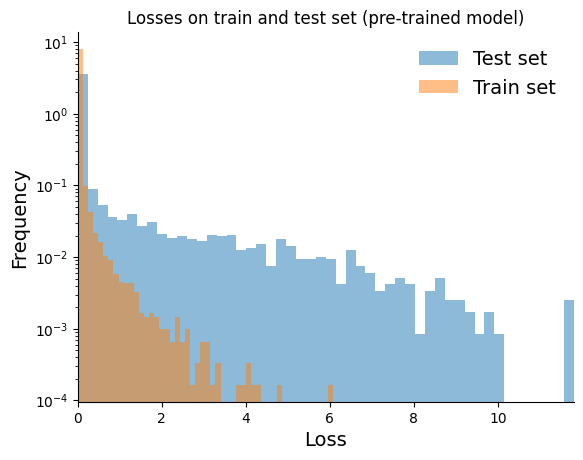

The MIA for the original model has an accuracy of 0.577 on forgotten vs unseen images
The MIA for unlearned model has an accuracy of 0.565 on forgotten vs unseen images


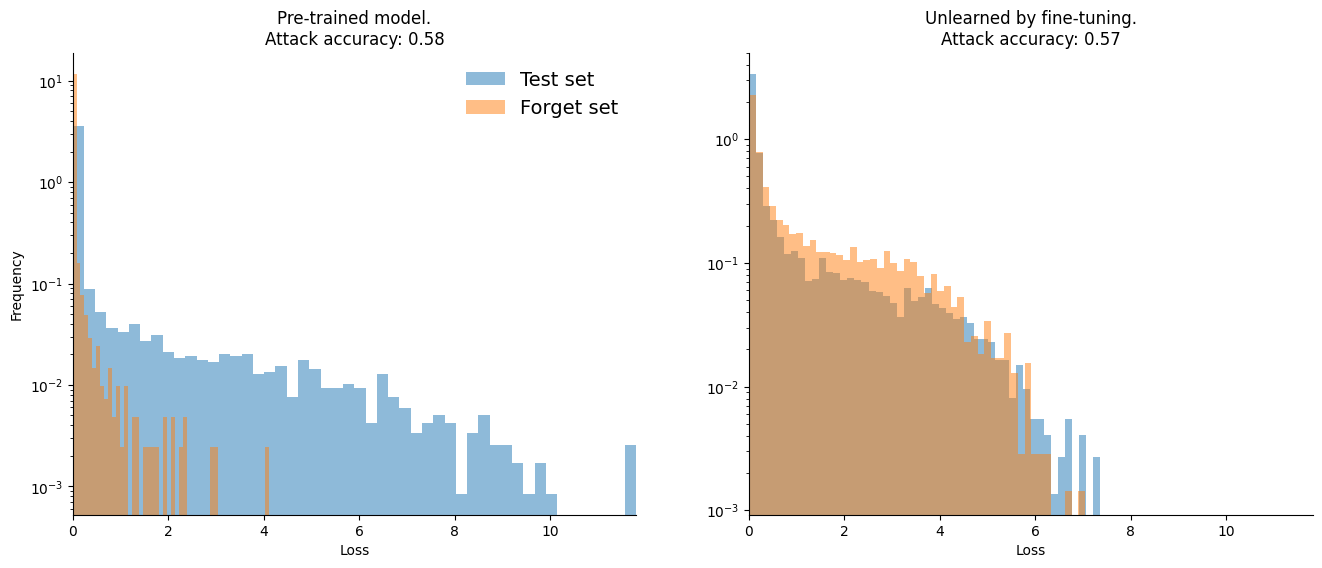

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%
The MIA for retrained model has an accuracy of 0.501 on forgotten vs unseen images


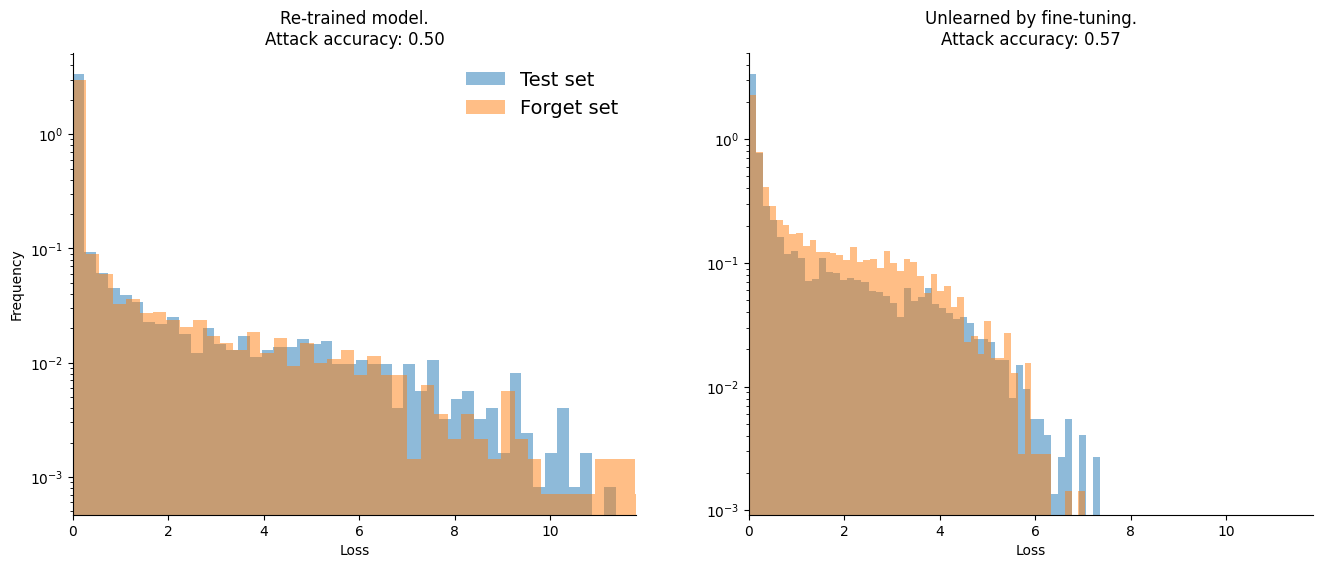

Our Score for unlearned model and forget loader: 0.9505301713943481


/home/bharatgptv/miniconda3/envs/unlearning/lib/python3.12/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Our Score for retrained model and forget loader: 0.8266878128051758
Our Score for original model and forget loader: 0.8176929950714111


In [27]:
blindspot_main(weights_pretrained)

/home/bharatgptv/miniconda3/envs/unlearning/lib/python3.12/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1 Unlearning Loss 0.03639113903045654
Epoch 2 Unlearning Loss 0.029736600816249847
Epoch 3 Unlearning Loss 0.028084568679332733
Epoch 4 Unlearning Loss 0.02685614302754402
Epoch 5 Unlearning Loss 0.025994200259447098
Epoch 6 Unlearning Loss 0.025524700060486794
Epoch 7 Unlearning Loss 0.025597430765628815
Epoch 8 Unlearning Loss 0.02538590133190155
Epoch 9 Unlearning Loss 0.024736056104302406
Epoch 10 Unlearning Loss 0.024697320535779
Total time taken for 10 iterations: 77.81 seconds
Retain set accuracy for unlearning model: 97.4%
Test set accuracy for unlearning model: 97.3%
Retain set accuracy for original model: 97.2%
Test set accuracy for original model: 96.3%


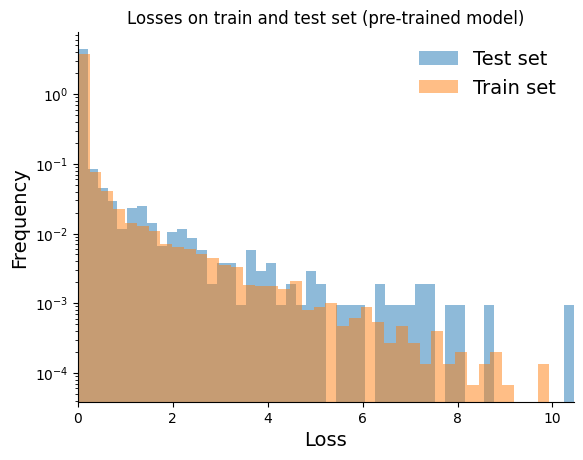

The MIA for the original model has an accuracy of 0.503 on forgotten vs unseen images
The MIA for unlearned model has an accuracy of 0.538 on forgotten vs unseen images


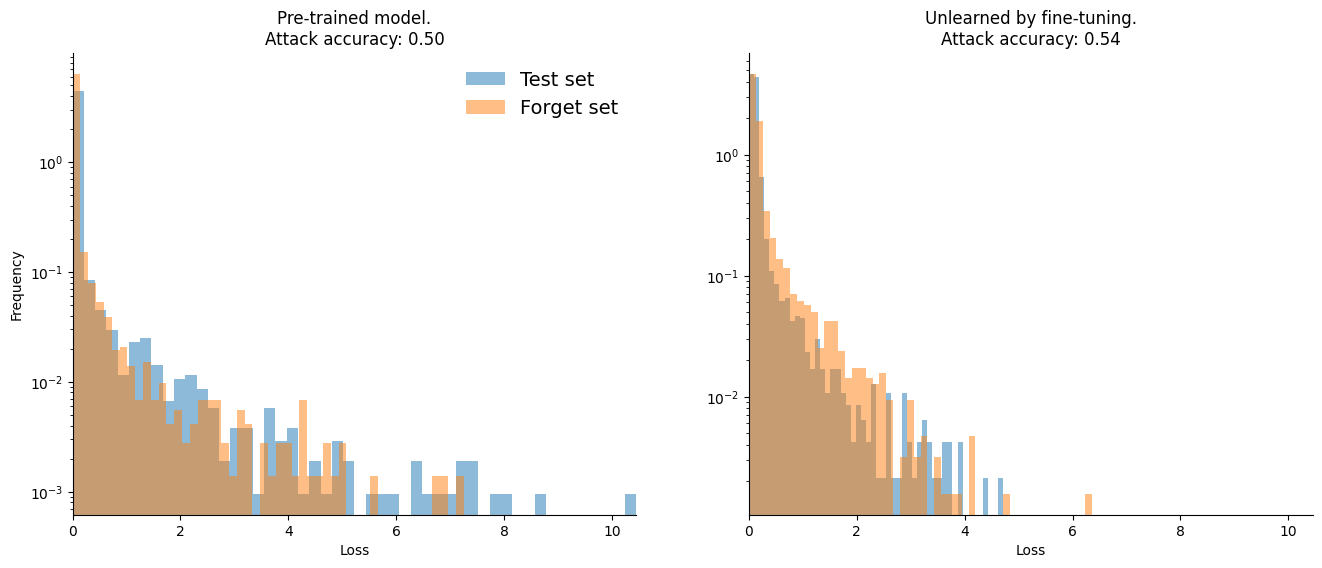

Retain set accuracy: 100.0%
Forget set accuracy: 98.0%
The MIA for retrained model has an accuracy of 0.500 on forgotten vs unseen images


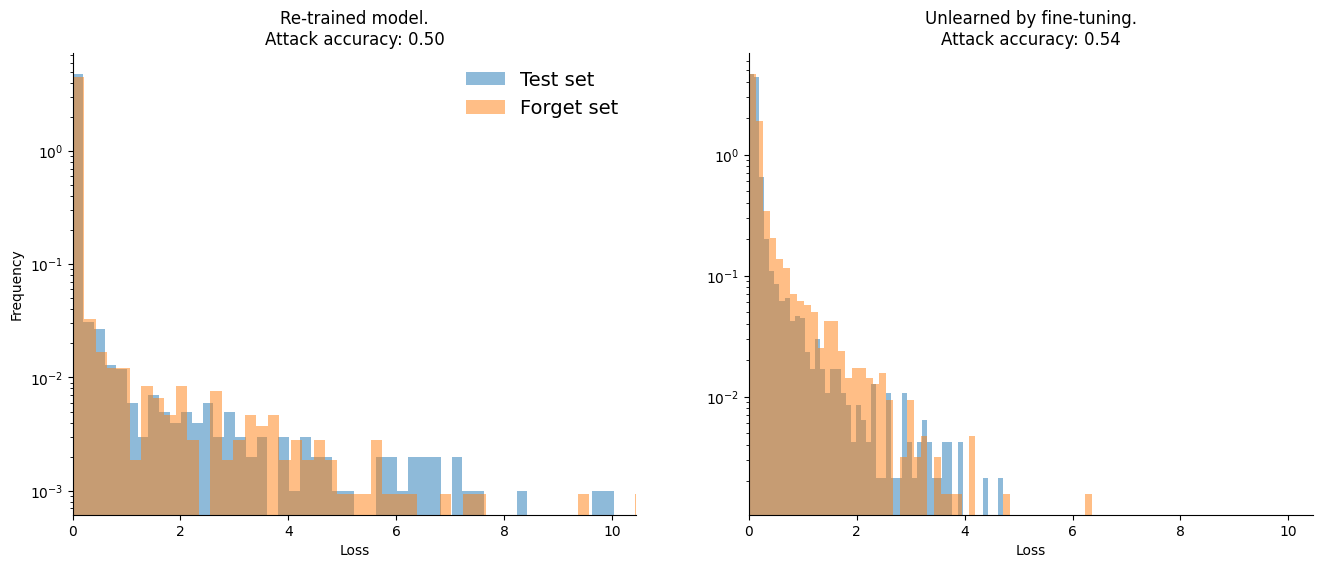

Our Score for unlearned model and forget loader: 0.9366650581359863


/home/bharatgptv/miniconda3/envs/unlearning/lib/python3.12/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Our Score for retrained model and forget loader: 0.7754191160202026
Our Score for original model and forget loader: 0.7722315192222595


In [41]:
blindspot_main(weights_pretrained, dataset_name=dataset_name)